#MEY | DIAGEO - METU System Design Project Heuristic Procedure Source Code **v 1.0**
- 3 alternatives of dedicated only, spot only and hybrid exist in this version
- Operations are done in morning and noon times twice a day. This is where the statistics are also collected
- Relevant performance measures can be calculated
- The code is split into 3 parts: Classes&Functions, Initializations and the Simulation. Later two parts are to be combined for serial testing and assesment
- Demand generation is based on frequency and quantity of the customers (see TBD 1)
- Service level calculations look for maximum of accumulated orders
- ZM's are special with their service level and benefit calculations
- Spot vehicle return time is tied to a seasonality factor which currently is static at 0.2
- All initial vehicle allocations are done considering no exit point should be left without vehicle 
- Contracted spot routes are assigned to spot vehicles after a routing is complete (Hybrid case) (see TBD 5)
#TO BE DONE:
- ***[WIP]TBD 0 New files are not added (distance, material)
- TBD 1 Demand data should be randomized and should come from customer segmentation with built-in seasonality. 
- ***[WIP] TBD 2 Tweaks to be done via genetic algorithm is not parametrized yet.
- TBD 3 Customers that have to be visited by lorries are not differentiated
- TBD 4 A counter for the number of times a route is used
- TBD 5 An alternative where cont. spot deliveries are planned beforehand 
- TBD 6 Automatic collection and assesment of the perf. measures
- TBD 7 Material shipment logic is not implemented
- TBD 8 Days since shipment can be held for each supply point (Satisfying a customer should depend on its problematic shipment not any shipment)
- TBD 9 Scenario where factories have dedicated vehicles
- ***[WIP]TBD 11 Test removing region restrictions since demand is kept seperately anyway
- TBD 12 Time windows are not added 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

In [ ]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



******
CLASSES AND FUNCTIONS
******

In [3]:
class vehicle():
    def __init__(self, tipp, plate, spot, base):
        self.stat = "wh"                    # status of the vehicle - this is not used - may be necessary later for dynamic tracking
        self.returned = True                # a vehicle is eligible for deliveries if this is true
        self.speed = 60                     # km/h is used for speed - currently static and never change within the code
        self.spot_factor = 1                # currently not used - intention was to multiply travel duration with this number to differentiate spot vehicle return time 
        self.plate = plate                  # plate number - will include inforamtion regarding its type
        self.spot = spot                    # indicates if a vehicle is a spot vehicle
        self.base = base                    # base exit point of the vehicle
        self.base_index = self.base.index   # index of the base - this calculated once here so that the base is not constantly called for its index
        self.tip = tipp                     # type of vehicle (truck or lorry)
        if tipp == "T":   self.cap = 33;        self.cost = 2.81; self.rem_cap = 33 # capacity, cost/km and capacity initializations according to their types (truck or lorry)
        else:             self.cap = 18;        self.cost = 2.48; self.rem_cap = 18

class make_fleet():
    def __init__(self, vehicles):   # vehicle array is given for the initialization of the fleet instance
        self.v = vehicles;        self.available_truck=0;        self.available_lorry=0 # actual available vehicle numbers are calculated in the next loop
        for vehicle in self.v:
            if vehicle.tip == "T":          self.available_truck+=1
            if vehicle.tip == "K":          self.available_lorry+=1
        self.havetruck = (self.available_truck > 0 )    # binary variables indicating the availability of vehicle types
        self.havelorry = (self.available_lorry > 0 )
    def v_left(self, v):            # relevant updates when a vehicle leaves
        if v.tip == "T": self.available_truck-=1;        
        else:  self.available_lorry-=1    
    def v_return(self, v):          # similar to above for returning vehicle
        if v.tip == "T":            self.available_truck+=1
        else:                       self.available_lorry+=1
    def avail_check(self):          # update for the binary availability variables
        self.havetruck = (self.available_truck > 0 )
        self.havelorry = (self.available_lorry > 0 )

class location():
    def __init__(self,name, tip, ind):
        self.name=name;        self.tip=tip;     self.index = ind; self.serviceLevel = [] # tip refers to customer type (distributor, zm, warehouse)
        self.acc_orders = [0,0,0,0,0,0,0];  self.days_since_ship = 0; self.passive = True  # acc_orders are 7 supply spoints (Geb, Nev, Ala, Bil, Şar, Mer)
        self.tr_o=0;
    # days_since_ship is used for delivery time calculations
    # passive is for eliminating no delivery locations from performance measure calculations
    def shipment_received(self):    # when any shipment is planned for the location, days since shipment is set to zero (See TBD 8)
        self.days_since_ship = 0
    def dayPassed(self):            # when a day passes and customer has demand above a certain number (conditions on when this function is called should examined below)
        self.days_since_ship += 1
    def w_o_truck(self,tr_dat):
        for i in range(len(tr_dat['Location'])):
            if tr_dat['Location'][i]==self.name:
                self.tr_o=tr_dat['Without truck'][i]


class output_statistic():           # this class holds various statistics regarding a shipment - created to simplfy the find_route function
    def __init__(self, quantities, veh, isinbound, distancesArr, totalemptydist, totDist):
        fillOfTravel = fill_rate(quantities, veh.cap, isinbound) # see fill_rate function for details
        fillbin = fill_rate_binary(quantities, isinbound)        # see fill_rate_binary function for details
        self.mean_fill = np.inner(fillOfTravel, distancesArr) / (sum(distancesArr)+.1) # calculations for generalized statistics components 
        self.mean_fill_bin = np.inner(fillbin, distancesArr) / (sum(distancesArr)+.1)  # +.1 prevents division by zero
        self.emptyDistRate = totalemptydist / (totDist+.1)

def load_distances (data_load, dist_df):    # preprocesing of the distance matrix
    total_locs = dist_df.shape[0]           # find the size of the matrix
    dis = np.zeros((total_locs,total_locs)) # empty matrix to be filled
    for i in range (total_locs):
        dis[i] = dist_df.iloc[i][1:total_locs+1]    # cleans out unused parts from the input
    data_load['distance_matrix'] = dis              # adds distances to the data dictionary
    return data_load                                # returns the dictionary

def load_demands (data_dem, customers, i):  # similar to the above function
    dem = []
    for loc in customers:
        dem.append(loc.acc_orders[i])
    data_dem['demands'] = dem
    return data_dem

def load_benefits_start(depots, plan):                      # inputs are the possible exit points and the vehicle allocation plan
    supply_point_number = 3 if plan == "ded_only" else 7    # dedicated only scenario does not consider factories as possible exit points (see TBD 9)
    benefits=[[] for i in range(supply_point_number)]       # benefit array starts empty for each exit point
    cur_max = [0 for i in range(supply_point_number)]       # each supply points champion benefit value is initially number
    cur_max_ind = [-1 for i in range(supply_point_number)]  # each suply points champion point is initialized as -1   
    for i in depots:                                        # note that for exit points not in the depots array, it is impossible for them to be selected from this function
        for k in range(len(customers)): benefits[i].append(0) # each benfit value is started as 0
        # note that previous for loop ends here but the outer one continues
        if i < 3:                       # for the warehouses' internal(wh->wh[for pickup] or wh->fac ) deliveries only
            for j in  range(7):         # for each supply point
                j_cus = j               # converting the numbers to use in distance matrix - see TBD 10
                if j == 3: j_cus = 164
                if j == 4: j_cus = 163
                if j == 5: j_cus = 166
                if j == 6: j_cus = 165
                multiplier = .7 if plan == "hybrid" else 1  # benefit multiplier for return trip locations - should be less encouraged for scenarios where every supply point has a vehicle(e.g hybrid)
                benefits[i][j_cus] += multiplier*1000 * int(customers[i+168].acc_orders[j]) / (data["distance_matrix"][i][j_cus] + 1 ) #accumulated order/distance for benefit heuristic
        for locat in customers:        # for external logistics (wh->wh[for delivery], wh -> customer)
            k = locat.index
            benefits[i][k] +=  1000 * int(locat.acc_orders[i]) / (data["distance_matrix"][wh_ind[i]][k] + 1)
            if dist_df.iloc[k]["belongs"] == i:          # locations in supply points' assigned region should get prioritized - see TBD 11
                benefits[i][k] *= 2 
            else:                                        # locations not in supply points' assigned region should be less prioritized - see TBD 11
                benefits[i][k] *= .5 
            if k in [0,1,2,164,163,166,165,168,169,170]: # compensation for internal logistics since region restrictions have negative effects on these
                benefits[i][k] *= 2
            if locat.tip == "zm":       benefits[i][k] *= 1.2 + .5 *locat.days_since_ship # benefit adjustment for days since shipment to prioritize - zms are critically affected
            else:                       benefits[i][k] *= 1   + .1 *locat.days_since_ship # these multipliers are subject to change and optimization - see TBD 2

        if i > 2 : benefits[i] = [2*q for q in benefits[i]] # doubles the benefit value for factories since their benefit values are less due to region mulitpliers
        cur_max[i] = np.max(benefits[i])                    # each supply point presents their champion
        cur_max_ind[i] = int(np.argmax(benefits[i]))        # each supply points' champions' indexes are kept
    chosen_wh_ind = int(np.argmax(cur_max))                 # most beneficial champion's exit point is selected
    chosen_dest_ind = cur_max_ind[chosen_wh_ind]            # most beneficial champion's index
    return [cur_max[chosen_wh_ind], chosen_wh_ind, chosen_dest_ind] # returns the final champion's benefit for threshold check and exit-destination pair

def load_benefits_start_spot(depots):       # similar function as above but for spot_only scenario - pickup portions are removed since they are not possible with spot
    benefits=[[] for i in range(7)]
    cur_max = [0 for i in range(7)]
    cur_max_ind = [-1 for i in range(7)]
    for i in depots:
        for k in range(len(customers)): benefits[i].append(0)
        #outbound
        for locat in customers:
            k = locat.index
            locat.w_o_truck(woTr)
            benefits[i][k] +=  1000 * int(locat.acc_orders[i]) / (data["distance_matrix"][wh_ind[i]][k] + 0.1)
            if dist_df.iloc[k]["belongs"] == i:
                benefits[i][k] *= 2 
            else:
                benefits[i][k] *= .5 
            if k in [0,1,2,164,163,166,165,168,169,170]:
                benefits[i][k] *= 2 
            if locat.tip == "zm":       benefits[i][k] *= 1.2 + .5 *locat.days_since_ship
            else:                       benefits[i][k] *= 1   + .1 *locat.days_since_ship
        cur_max[i] = np.max(benefits[i])
        cur_max_ind[i] = int(np.argmax(benefits[i]))
    chosen_wh_ind = int(np.argmax(cur_max))
    chosen_dest_ind = cur_max_ind[chosen_wh_ind]
    return [cur_max[chosen_wh_ind], chosen_wh_ind, chosen_dest_ind]

def find_vehicle(chosen_wh_ind, chosen_dest_ind, lookForSpot):
    i = chosen_wh_ind
    j = chosen_dest_ind
    for locat in customers:
      if locat.index==j:
        tr_avail=locat.tr_o
    q = customers[chosen_dest_ind].acc_orders[i]        # quantity that is desired to be carried
    vehiclefound=False                                  # start as false - it should remain as such until a cehicle is found
    limitForTruck = [0 if lookForSpot else 8][0]        # should never look for lorry if a spot vehicle is needed since there aren't any spot lorries
    if q > limitForTruck or (chosen_dest_ind in [0,1,2,164,163,166,165]): # internal logistics are always done via trucks since their quantities are not directly demand-dependent
        if fleets[i].havetruck and (not tr_avail):  desired = "T"
        elif lookForSpot:                           # note that lookForSpot is given as true is there are no available dedicated trucks (for hybrid case) (see main simulation below)
            for v in spot_fleets[i].v:              # searches for an available spot vehicle
                if not vehiclefound and v.returned:
                    v.returned = False
                    spot_fleets[i].v_left(v); spot_fleets[i].avail_check()
                    vehiclefound=True
                    return v                        # function ends here if a vehicle is found
            if (not vehiclefound) and (tr_avail): desired = "K"      # truck was desired but not found, then look for a lorry
        else:     desired = "K"                     # truck was desired but none are in the fleet, then look for a lorry
    else: desired = "K"                             # if quantity is low and it is external shipment, look for a lorry
    for v in fleets[i].v:                           # for dedicated vehicle search and assignment
        if v.returned and v.tip == desired and not vehiclefound:
            v.returned = False
            fleets[i].v_left(v); fleets[i].avail_check()
            vehiclefound=True
            return v
    if not vehiclefound: return 0

def load_benefits_route(cur_loc, vhc, routeSoFar, is_spot): # benefit assesment for destination selection while moving through the route
    wh_i = vhc.base_index                   
    if vhc.base_index == 164: wh_i = 3
    if vhc.base_index == 163: wh_i = 4
    if vhc.base_index == 166: wh_i = 5
    if vhc.base_index == 165: wh_i = 6      # conversion for indices - see TBD 10
    benefits= []                            # similar initializations as the function above but for a single exit point
    cur_max = []
    cur_max_ind = []
    i = vhc.base_index
    if cur_loc in [0,1,2, 164, 163, 166,165]: # if you are at a pickup location, return fail so returning trip is set up in the outer function (find_route)
        return "fail"
    else:
        for locat in customers:
            if (vhc.tip == 'T'): 
                if locat.index not in routeSoFar:
                    if locat.tr_o:
                        benefits.append(0);
                    else:
                        benefits.append( 1000 * np.min([int(locat.acc_orders[wh_i]), vhc.rem_cap]) / ((data["distance_matrix"][cur_loc][locat.index]) + 0.01) )
                        if dist_df.iloc[locat.index]["belongs"] == i:   benefits[locat.index] *=  2 # locations in supply points' assigned region should get prioritized - see TBD 11
                        else:                                           benefits[locat.index] *= .5 # locations not in supply points' assigned region should be less prioritized - see TBD 11
                        if locat.tip == "zm":       benefits[locat.index] *= 1.1 + .15 * locat.days_since_ship   # less severe differences and effects since route planning should be more distnce focused
                        else:                       benefits[locat.index] *= 1   + .1  * locat.days_since_ship  
                        if locat.index  in [0,1,2,164,163,166,165] and not is_spot: # for pick up locations
                            j_cus = locat.index
                            if locat.index == 164: j_cus = 3
                            if locat.index == 163: j_cus = 4
                            if locat.index == 166: j_cus = 5
                            if locat.index == 165: j_cus = 6    # conversion for indices - see TBD 10
                            benefits[locat.index] =  1000 * customers[i+168].acc_orders[j_cus] / ((data["distance_matrix"][cur_loc][locat.index])**1.2 + 0.01)
                            benefits[locat.index] *= (2*vhc.cap - vhc.rem_cap)/vhc.cap  # pickup locations should be more desirable for a vehicle using most of its capacity so return trips are utilized without delivery trip sacrifice
                        elif locat.index  in [168,169,170] and not is_spot:         
                            benefits[locat.index] = benefits[locat.index] * 4           # compensation for regional multiplier for factories    
                            if len(routeSoFar) < 4:                                     # if a return trip is still possible, warehouses' receiver clones should get pick up benefit as well
                                benefits[locat.index] += benefits[locat.index - 168]    
                else:               # if a place is already visited give its benefit as 0
                    benefits.append(0)
            else:
                if locat.index not in routeSoFar:
                    benefits.append( 1000 * np.min([int(locat.acc_orders[wh_i]), vhc.rem_cap]) / ((data["distance_matrix"][cur_loc][locat.index]) + 0.01) )
                    if dist_df.iloc[locat.index]["belongs"] == i:   benefits[locat.index] *=  2 # locations in supply points' assigned region should get prioritized - see TBD 11
                    else:                                           benefits[locat.index] *= .5 # locations not in supply points' assigned region should be less prioritized - see TBD 11
                    if locat.tip == "zm":       benefits[locat.index] *= 1.1 + .15 * locat.days_since_ship   # less severe differences and effects since route planning should be more distnce focused
                    else:                       benefits[locat.index] *= 1   + .1  * locat.days_since_ship  
                    if locat.index  in [0,1,2,164,163,166,165] and not is_spot: # for pick up locations
                        j_cus = locat.index
                        if locat.index == 164: j_cus = 3
                        if locat.index == 163: j_cus = 4
                        if locat.index == 166: j_cus = 5
                        if locat.index == 165: j_cus = 6    # conversion for indices - see TBD 10
                        benefits[locat.index] =  1000 * customers[i+168].acc_orders[j_cus] / ((data["distance_matrix"][cur_loc][locat.index])**1.2 + 0.01)
                        benefits[locat.index] *= (2*vhc.cap - vhc.rem_cap)/vhc.cap  # pickup locations should be more desirable for a vehicle using most of its capacity so return trips are utilized without delivery trip sacrifice
                    elif locat.index  in [168,169,170] and not is_spot:         
                        benefits[locat.index] = benefits[locat.index] * 4           # compensation for regional multiplier for factories    
                        if len(routeSoFar) < 4:                                     # if a return trip is still possible, warehouses' receiver clones should get pick up benefit as well
                            benefits[locat.index] += benefits[locat.index - 168]    
                else:               # if a place is already visited give its benefit as 0
                    benefits.append(0)

        cur_max = (np.max(benefits))
        cur_max_ind = (int(np.argmax(benefits)))
        if cur_max > thresholds[wh_i]:              # check for the benefit threshold for the champion
            return cur_max_ind
        else: return "fail"                         # if champion is a failure this later removes this exit point from the list

def find_route(strprint, v, current_loc_ind, spot): # after exit point, 1st destionation and vehicle is found, this function constructs the whole route 
    wh_index = v.base_index
    if v.base_index == 164: wh_index = 3
    if v.base_index == 163: wh_index = 4
    if v.base_index == 166: wh_index = 5
    if v.base_index == 165: wh_index = 6        # conversion for indices - see TBD 10
    routeLimit= 7
    routes    = []
    quants    = []
    distances = []
    totalEmptyDistance = 0
    routes.append(v.base_index)                     # start the route with the base
    distance = data["distance_matrix"][v.base_index][current_loc_ind]       #first piece of the distance
    total_distance =  distance
    distances.append(distance)                      # save the distance in the distances array for performance measure calculation
    if current_loc_ind in [0,1,2, 164, 163, 166,165]: totalEmptyDistance += distance    # if going for pickup, it is an empty travel
    routes.append(current_loc_ind)                  # since the first destination is known(as current_loc_ind) before the call to this function, add it to the route
    customers[current_loc_ind].shipment_received()  # have the customer satisfied
    next_target = current_loc_ind                   # set the next_target (no reason other than the strcuture of the following loop)
    inbound = False                                 # for the statistics collection (changes the return to a full loaded trip)
    while True:     #loop is only broken by break command
        if next_target in [0,1,2, 164, 163, 166,165]:   # if your current location is a pick up point
            j_cus = next_target
            if next_target == 164: j_cus = 3
            if next_target == 163: j_cus = 4
            if next_target == 166: j_cus = 5
            if next_target == 165: j_cus = 6        # conversion for indices - see TBD 10
            quant = v.cap                           # internal logistics are always fully loaded since their quantities are not directly demand-dependent
            quants.append(0)                        # going empty to the pickup(supply) point
            customers[v.base_index+168].acc_orders[j_cus] -= quant                      # this exit point's receiver clone should have its demand reduced since there is a bring-back
            strprint += " -> " + customers[next_target].name + "(given:" + "0" + ")"    
            distance = data["distance_matrix"][next_target][v.base_index]               # set the return trip back to base
            total_distance +=  distance
            distances.append(distance)  
            routes.append(v.base_index)                                                 # add the base to the route since this is a return trip
            customers[v.base_index].shipment_received()                                 # base is satisfied (because it is a return trip)
            strprint += " -> " + customers[v.base_index].name + "(taken:" + str(v.cap) +")"
            inbound = True  # set this to true for proper statistics calculation
            break           # break the while loop (route is terminated)
        elif next_target != "fail": # if the vehicle is not at a supply point or route is not terminated by the load_benefits_route function
            quant = int(np.min([v.rem_cap,   customers[next_target].acc_orders[wh_index]])) # maximum amount that can be carried is bounded by the remaining capacity and the demand
            quants.append(quant)
            v.rem_cap -= quant          # reduce the remaining capacity by the amount decided above
            customers[next_target].acc_orders[wh_index] -= quant #  update the demand by the carried amount
            strprint += " -> " + customers[next_target].name + "(given:" + str(quant) +")"

        current_loc_ind = next_target   # update the current location since next_target will be the actual next destination
        next_target = "fail" if len(routes) >= routeLimit else load_benefits_route(next_target, v, routes, spot)  # stop routing if the limit is reached otherwise call the function to find next stop

        if next_target != "fail":       # if next_target is returned
            distance = data["distance_matrix"][current_loc_ind][next_target]   
            total_distance +=  distance
            distances.append(distance)
            routes.append(next_target)
            customers[next_target].shipment_received()      
            if next_target in [0,1,2, 164, 163, 166, 165]: totalEmptyDistance += distance   # if you decided to go to a supply point, you went there empty
        if next_target == "fail":       # if no satisfactory destination available
            if not spot:                # return trip calculations are skipped for spot vehicles
                quants.append(0)        # return trip is empty
                strprint += " -> " + customers[v.base_index].name
                distance = data["distance_matrix"][current_loc_ind][v.base_index]#going
                total_distance +=  distance
                distances.append(distance)
                routes.append(v.base_index) # end the route with the base
                if current_loc_ind not in [0,1,2, 164, 163, 166,165]: totalEmptyDistance += distance # if you returned from a "non-supply" point, you returned empty
            break
    st = output_statistic(quants, v, inbound, distances, totalEmptyDistance, total_distance)         # statistics are compiled
    return [routes, total_distance, strprint, st]               # return complete route, distance, the message and the statistics object

def fill_rate(quant_arr, capacity, inb):    # calculates the fill rate through the route considering the drops and pick ups
    fillOnRoad =[]
    start_load = sum(quant_arr)
    curLoad=start_load
    for r in range(len(quant_arr)):
        fillOnRoad.append(curLoad/capacity)
        curLoad -= quant_arr[r]
    if inb:     # internal logistics return trips are fully loaded so %100 is added
        fillOnRoad.append(1)
    return fillOnRoad

def fill_rate_binary(quant_arr,inb):    # similar as above but only calculates if the vehicle is totally empty or not
    fillOnRoad =[]
    start_load = sum(quant_arr)
    curLoad=start_load
    for r in range(len(quant_arr)):
        if curLoad > 0:
            fillOnRoad.append(1)
        else:
            fillOnRoad.append(0)
        curLoad -= quant_arr[r]
    if inb:
        fillOnRoad.append(1)
    return fillOnRoad

def prepare_fleet(trucks, lorries, wantSpot):   # creates an array of fleets with given vehicle numbers
    i=0 # increases at the end of the loop for 0 through 7 version of the base indices
    for j in [0,1,2, 164, 163, 166, 165]:       # conversion for indices (with i and j) - see TBD 10
        trucknumber=1;   lorrynumber=1;   fleetAtHand=[]
        while trucks[i] + lorries[i] > 0:       # this basically creates the vehicle arrays with changing vehicle plate numbers and correct types
            if trucks[i] >0:
                p = "S" if wantSpot else "D"
                name = "34 "+p+ "T 0" + str(trucknumber)
                fleetAtHand.append(vehicle("T", name, spot=wantSpot, base=customers[j]))
                trucknumber+=1
                trucks[i] -=1
            if lorries[i] >0:
                p = "S" if wantSpot else "D"
                name = "34 "+p+ "K 0" + str(lorrynumber)
                fleetAtHand.append(vehicle("K", name, spot=wantSpot, base=customers[j]))
                lorrynumber+=1
                lorries[i] -=1
        if not wantSpot:    # correctly names the fleets 
            if i == 0: fleet_geb = make_fleet(fleetAtHand)
            if i == 1: fleet_nev = make_fleet(fleetAtHand)
            if i == 2: fleet_ala = make_fleet(fleetAtHand)
            if i == 3: fleet_bil = make_fleet(fleetAtHand)
            if i == 4: fleet_sar = make_fleet(fleetAtHand)
            if i == 5: fleet_ela = make_fleet(fleetAtHand)
            if i == 6: fleet_mer = make_fleet(fleetAtHand)
        else:
            if i == 0: spot_fleet_geb = make_fleet(fleetAtHand)
            if i == 1: spot_fleet_nev = make_fleet(fleetAtHand)
            if i == 2: spot_fleet_ala = make_fleet(fleetAtHand)
            if i == 3: spot_fleet_bil = make_fleet(fleetAtHand)
            if i == 4: spot_fleet_sar = make_fleet(fleetAtHand)
            if i == 5: spot_fleet_ela = make_fleet(fleetAtHand)
            if i == 6: spot_fleet_mer = make_fleet(fleetAtHand)
        i+=1
    if wantSpot:    # names the array of fleets
        prepared_fleets = [spot_fleet_geb, spot_fleet_nev, spot_fleet_ala,
                           spot_fleet_bil, spot_fleet_sar, spot_fleet_ela, spot_fleet_mer]
    else:
        prepared_fleets = [fleet_geb, fleet_nev, fleet_ala,fleet_bil,fleet_sar,fleet_ela,fleet_mer]
    return prepared_fleets

def spot_cost_calculator(route, dist, vv, c_routes, c_costs):
    j=0
    for r in c_routes:
        if route[0:2] == r and len(route) < 4:  # searches the first two pieces of the route among contracted routes if it is not extended beyond 3 points (includig return)
            print("Contracted route detected")  
            return [c_costs[j],0]               # returns the cost of the contract if route is matched with it
        j+=1
    #theCost = (dist + data["distance_matrix"][route[-1]][vv.base_index])* vv.cost
    theCost = dist * vv.cost    # if it is not among the contracted routes, just return regular cost
    return [theCost, data["distance_matrix"][route[-1]][vv.base_index]*vv.cost ]

def spot_converter(routeToCheck, c_routes, prev_vehicle):   # makes a delivery spot if desired
    if prev_vehicle.spot:              #skip this function if the vehicle is already spot                     
        return [prev_vehicle, True]
    routeToCheck = routeToCheck[0:-1]                       # excludes the return trip for a possible spot route
    base_ind=prev_vehicle.base_index                        # the base will not change 
    if prev_vehicle.base_index == 164: base_ind = 3
    if prev_vehicle.base_index == 163: base_ind = 4
    if prev_vehicle.base_index == 166: base_ind = 5
    if prev_vehicle.base_index == 165: base_ind = 6         # conversion for indices - see TBD 10
    spot_available = spot_fleets[base_ind].havetruck if prev_vehicle.tip=="T" else spot_fleets[base_ind].havelorry  #checks the availability of a desired spot vehicle type based on current vehicle's type
    if routeToCheck in c_routes and spot_available:         # conversion only happens if the route is a contracted route and a spot vehicle is available
        converted=True
        print("Converted to spot delivery!")
        j=0         # index of the chosen spot vehicle within its fleet (we can not  make changes to the vehicle directly since it is a global variable but we are in a function)
        for vehc in fleets[base_ind].v:             # unassigns the previously assigned dedicated vehicle
            if vehc.plate == prev_vehicle.plate:
                fleets[base_ind].v[j].returned = True
                fleets[base_ind].v_return(prev_vehicle); fleets[base_ind].avail_check()     #regular updates to the fleet after a change
                break                               # if the previously assigned vehicle is found, no need to search further
            j+=1
        for vehc in spot_fleets[base_ind].v:        # searches and assigns a spot vehicle
            if vehc.returned and vehc.tip == prev_vehicle.tip:
                vehc.returned = False
#                vehc.return_time = prev_vehicle.return_time*2 #  """this is handled outside the function"""
                spot_fleets[base_ind].v_left(vehc); spot_fleets[base_ind].avail_check() #regular updates to the fleet after a change
                break
        return [vehc, converted]
    else:
        converted=False
        return [prev_vehicle, converted]

#rota sayılarının export edileceği excel path;
pat_part=r'C:\Users\ASUS_PC\Desktop\Mey\rota_sayıları_partial.xlsx'
pat_tot=r'C:\Users\ASUS_PC\Desktop\Mey\rota_sayıları_total.xlsx'

def unique(list1):
    
    unique_list = []
    
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def route_appender(lst,route):
    lst.append(route)
    return lst

def route_counter(lst,custs):
  elements=[]; cntr=[]; total2=[]; son_list=[];
  for i in lst:  
    total= []; partial_el=[];
    a=""
    for j in range(len(i)):
      if j==0:
        strt=custs[i[j]].name
      else:
        partial_el.append(custs[i[j]].name)
   
      if not j==(len(i)-1):
        a+=str(custs[i[j]].name) + "-" 
      else:
        a+=str(custs[i[j]].name)
    elements.append(a)
    for k in partial_el:
      general_partial_rts=[];
      general_partial_rts.append(strt)
      general_partial_rts.append(k)
      total.append(general_partial_rts)
    total2.append(total)
  
  num_rt=[]; nam_rt=[];nam_partial=[];num_partial=[];
  p_un=unique(elements);
  for i in range(len(p_un)):
    b=""
    p=elements.count(p_un[i])
    b+=str(elements[i])+ " " +"->" +"count:"+str(p)
    cntr.append(b); nam_rt.append(p_un[i]); num_rt.append(p)
  
  for iterat in (total2):
    for iterat2 in range(len(iterat)):
      son_list.append(iterat[iterat2])

  s_un=unique(son_list)
  for ist in range(len(s_un)):
      cc=son_list.count(s_un[ist])
      nam_partial.append(s_un[ist]); num_partial.append(cc)
  return cntr,nam_rt,num_rt,nam_partial,num_partial,son_list

def counter_to_dataFrame(name,num):
    d={"rota":name,"sayı":num}
    df=pd.DataFrame(d)
    return df
    
  

********
INITIALIZATIONS
******

In [4]:
woTr=pd.read_excel(r"/content/drive/MyDrive/MEYYO/without_truck.xlsx")
dist_df = pd.read_excel(r"/content/drive/MyDrive/MEYYO/distances (2).xlsx")
loc_type_df = pd.read_excel(r"/content/drive/MyDrive/MEYYO/musteri_tip.xlsx")
data = {}
data = load_distances(data, dist_df)
customers = []
for i in range(dist_df.shape[0]):           # construction of customes array of location objects
    name = str(dist_df.iloc[i]["FROM/TO"])  # names are from distance dataframe
    if loc_type_df.loc[loc_type_df.place == name].empty:        # types are taken
        t = "na"
        if i in [168,169,170]:            t = "wh"              # receiver clones of warehouses
    else:        t=loc_type_df.loc[loc_type_df.place == name].iloc[0].tip   # rest of locations' types
    customers.append(location(str(dist_df.iloc[i]["FROM/TO"]), t, i))   # add it to the list
    
    # ALL THE FACTORY FLEETS ARE NOW CONSTRUCTED VIA PREPARE_FLEET

vehicles_bil = [   #SET UP VEHICLES (tip, plaka, spot mu?, merkez depo)
#            vehicle("T", "34 STB 1", spot=True, base = customers[164]),           vehicle("T", "34 STB 2", spot=True, base = customers[164]),
#            vehicle("T", "34 STB 3", spot=True, base = customers[164]),           vehicle("T", "34 STB 4", spot=True, base = customers[164]),
#            vehicle("K", "34 SKB 5", spot=True, base = customers[164]),           vehicle("K", "34 SKB 6", spot=True, base = customers[164]),
]
fleet_bil = make_fleet(vehicles_bil) #make the fleet with vehicle array
vehicles_mer = [   #SET UP VEHICLES (tip, plaka, spot mu?, merkez depo)
#            vehicle("T", "34 STM 1", spot=True, base = customers[165]),           vehicle("T", "34 STM 2", spot=True, base = customers[165]),
#            vehicle("T", "34 STM 3", spot=True, base = customers[165]),           vehicle("K", "34 SKM 4", spot=True, base = customers[165]),
]
fleet_mer = make_fleet(vehicles_mer) 
vehicles_sar = [   #SET UP VEHICLES (tip, plaka, spot mu?, merkez depo)
#            vehicle("T", "34 STS 1", spot=True, base = customers[163]),           vehicle("T", "34 STS 2", spot=True, base = customers[163]),
#            vehicle("T", "34 STS 3", spot=True, base = customers[163]),           vehicle("K", "34 SKS 4", spot=True, base = customers[163]),
]
fleet_sar = make_fleet(vehicles_sar) #make the fleet with vehicle array
vehicles_ela = [   #SET UP VEHICLES (tip, plaka, spot mu?, merkez depo)
#            vehicle("T", "34 STE 1", spot=True, base = customers[166]),           vehicle("T", "34 STE 2", spot=True, base = customers[166]),
#            vehicle("T", "34 STE 3", spot=True, base = customers[166]),           vehicle("K", "34 SKE 4", spot=True, base = customers[166]),
]
fleet_ela = make_fleet(vehicles_ela) # make the fleet with vehicle array
vehicles_geb = [   # SET UP VEHICLES (tip, plaka, spot?, base)
            vehicle("T", "34 DTG 1", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 2", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 3", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 4", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 5", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 6", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 7", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 8", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 9", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 10", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 11", spot=False, base = customers[0]),
            vehicle("T", "34 DTG 12", spot=False, base = customers[0]),
            ###
            vehicle("K", "34 DKG 13", spot=False, base = customers[0]),
            vehicle("K", "34 DKG 14", spot=False, base = customers[0])
            ]
fleet_geb = make_fleet(vehicles_geb) # make the fleet with vehicle array

vehicles_nev = [   #SET UP VEHICLES (tip, plaka, spot?, base)
            vehicle("T", "34 DTN 1", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 2", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 3", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 4", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 5", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 6", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 7", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 8", spot=False, base = customers[1]),
            vehicle("T", "34 DTN 9", spot=False, base = customers[1]),
            ###
            vehicle("K", "34 DKN 10", spot=False, base = customers[1]),
            vehicle("K", "34 DKN 11", spot=False, base = customers[1]),
            vehicle("K", "34 DKN 12", spot=False, base = customers[1]),
            vehicle("K", "34 DKN 13", spot=False, base = customers[1]),
            vehicle("K", "34 DKN 14", spot=False, base = customers[1]),
            vehicle("K", "34 DKN 15", spot=False, base = customers[1])
            ]
fleet_nev = make_fleet(vehicles_nev)

vehicles_ala = [   # SET UP VEHICLES (tip, plaka, spot mu?, base)
            vehicle("T", "34 DTA 1", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 2", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 3", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 4", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 5", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 6", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 7", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 8", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 9", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 10", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 11", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 12", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 13", spot=False, base = customers[2]),
            vehicle("T", "34 DTA 14", spot=False, base = customers[2]),
            #vehicle("T", "34 DTA 15", spot=False, base = customers[2]), # this vehicle was not used after day 1 so it is removed altogether
            ###
            vehicle("K", "34 DKA 15", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 16", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 17", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 18", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 19", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 20", spot=False, base = customers[2]),
            vehicle("K", "34 DKA 21", spot=False, base = customers[2])
            ]
fleet_ala = make_fleet(vehicles_ala)

current_plan = "hybrid"          # declare the policy for vehicles

if current_plan == "hybrid":        # hybrid scenario takes real dedicated numbers and enough spot vehicles to never run out of vehicles
    fleets      = [fleet_geb, fleet_nev, fleet_ala, fleet_bil, fleet_sar, fleet_ela, fleet_mer]
    spot_fleets = prepare_fleet(trucks=[10,10,10,5,3,3,3], lorries = [0,0,0,0,0,0,0], wantSpot=True)
elif current_plan == "spot_only":   # spot only scenario takes empty dedicated fleets and enough spot vehicles to never run out of vehicles
    fleets      = prepare_fleet(trucks=[0,0,0,0,0,0,0], lorries = [0,0,0,0,0,0,0], wantSpot=False)
    spot_fleets = prepare_fleet(trucks=[25,22,31,8,3,3,6], lorries = [0,0,0,0,0,0,0], wantSpot=True)
elif current_plan == "ded_only":    # dedicated only scenario takes enough dedicated vehicles to never run out of vehicles
    fleets =     prepare_fleet(trucks=[20,19,20,0,0,0,0], lorries = [4,8,7,0,0,0,0], wantSpot=False)
    spot_fleets =prepare_fleet(trucks=[0,0,0,0,0,0,0],    lorries = [0,0,0,0,0,0,0], wantSpot=True)
#fleets = prepare_fleet(trucks=[24,22,24,8,6,6,6], lorries = [12,16,12,5,4,4,4], wantSpot=False)
demand_period = 1                   # for homogenous demand renewal - not relevant for other renewal types
demands_oct = pd.read_excel(r"/content/drive/MyDrive/MEYYO/totaldemand_new.xlsm")
demands_oct["periodic_demand"] = demands_oct.total_demand / (30/demand_period)  # generate demand amounts to update each day
demands_oct["norm_periodic"] = demands_oct.norm_demand / demands_oct.norm_count

*****
SIMULATION
*****

In [5]:
plan_for = current_plan     # plan is initalized in the previous cell due to fleet generation differences between scenarios
demand_plan = "frequency"   # selected demand renewal type
maxdays = 30                # max length of the simulation in days
time_increment =  .25       # how much time will pass each iteration in days - quarter of a day passes between morning and noon (evening and midnight is skipped in the simulation)
bound_with_truck = 15       # vehicle selection thresholds - same for spot and dedicated since there is no route limit difference between them anymore - see TBD 9
bound_with_lorry = 10
exit_points = 3 if plan_for== "ded_only" else 7         # dedicated only only takes only warehouses as possible starting points
total_cost = [0 for q in range(exit_points)]            # empty initializations for statistics
totalReturnCost = [0 for q in range(exit_points)]       # this is different because it is kept individually for exit points, the rest are for all routes AND warehouses
all_distances = [[] for q in range(exit_points)]
all_empty_distances = [[] for q in range(exit_points)]
all_mean_fill = [[] for q in range(exit_points)]
all_mean_fill_bin = [[] for q in range(exit_points)]
vehicle_avail = [[] for q in range(exit_points)]
#unsat_dem    = [[] for q in range(exit_points)]           # unsatisfied demand remaining - not used currently
contracted_routes = [[2,0+168], [1,0+168],[166,1+168], [1,2+168]]   # list of contracted routes - for delivery back to warehouses their receiver clones are used ( i+168 takes i to its clone)
contracted_costs = [2734, 3092, 2925, 3786]                         # costs for contracted routes - has to be in the same order as the routes above
wh_ind = [0,1,2, 164, 163, 166, 165]                                # conversion for indices - see TBD 10
tot_route=[];
for time in np.linspace(0,maxdays,int(1 + maxdays / time_increment)):     # iterates through time points according to parameters above
    if time%1 ==0:                  # start of the day is morning
        print("\n### DAY ", int(time+1), " MORNING ###")
    if time%1 ==.25:                # one quarter day later is the noon
        print("\n### DAY ", int(time+1), " NOON ###")
    if time%1 < .5:                 # simulation does stuff only if it is morning or noon
        if time%1 <.25:             # demands only get renewed if it is morning - could be different but a minor detail
            for cust in customers:  # unsatisfied customer check for days since shipment
                if cust.tip == "zm":# zm type customers are effected more severly by unsatisfied orders
                    if np.max(cust.acc_orders) > 0: cust.dayPassed()
                else: 
                    if np.max(cust.acc_orders) > 3: cust.dayPassed()
        for i in range(exit_points):                                                            # updates vehicle returns for all exit point
            for fleetArray in [fleets, spot_fleets]:                                            # for dedicated and spot fleets
                for v in fleetArray[i].v:                                                       # for every vehicle...
                    if not v.returned and (v.return_time < time):                               # if its returned status is false and return time has come already...
                        v.returned = True; fleetArray[i].v_return(v); v.rem_cap = v.cap         # update it as returned and update fleet with the vehicle (see v_return func. above)
                        if plan_for != "spot_only":
                            print("#RETURN: ",v.plate, " returned to ", v.base.name)            # print the return
            fleets[i].avail_check();spot_fleets[i].avail_check()                                # regular updates to the fleet after a change

            if demand_plan == "daily_homogenous":                   # not used, so only the other demand version is explained
                if (time-1)%int(demand_period) == 0 and time != maxdays:
                    for locat in customers:
                        if not locat.index in [168,169,170]:
                            sub_dem = demands_oct.loc[(demands_oct.from_place == customers[wh_ind[i]].name)  &  (demands_oct.to_place == locat.name)]
                            if not sub_dem.empty:
                                if not locat.index in [0,1,2]:
                                    locat.acc_orders[i] += int(sub_dem["periodic_demand"].iloc[0]) + 1
                                    locat.passive = False
                                else: 
                                    customers[locat.index + 168].acc_orders[i] += int(sub_dem["periodic_demand"].iloc[0]) + 1
                                    customers[locat.index + 168].passive = False

            elif demand_plan == "frequency" :                       # updates demand according to its frequency and normalized quantity
                for locat in customers:                             # for each location (customers array holds every location including non customers)
                    if not locat.index in [168,169,170]:            # receiver clones catch the demand of warehouses
                        sub_dem = demands_oct.loc[(demands_oct.from_place == customers[wh_ind[i]].name)  &  (demands_oct.to_place == locat.name)] #slice of the dataframe for the location and the exit point
                        if not sub_dem.empty:                                                       # if there is a demand record for this pair
                            if time % int(30/sub_dem["norm_count"]) == 0 and time != maxdays:       # if it is time (frequency is considered here)
                                if not locat.index in [0,1,2]:                                      # warehouses' demand are caught by receiver clones
                                    locat.acc_orders[i] += int(sub_dem["norm_periodic"].iloc[0])+1  # amount found is added
                                    locat.passive = False                                           # if demand renewal happened this location is not passive (not excluded from statistics)    
                                else:
                                    customers[locat.index + 168].acc_orders[i] += int(sub_dem["norm_periodic"].iloc[0])+1  # warehouses' demand are caught by receiver clones 
                                    customers[locat.index + 168].passive = False
            

        if (int(time)+1)%7 != 0 and int(time)%7 !=0:                # shipments happen if it is not a weekend
            if plan_for == "spot_only":
                possible_depots =[d for d in range(7)]              # start each day with all exit points eligible for a route start
                thresholds = [80,45,50, 50,50,50,50]                # thresholds for each exit point for a destination approval see TBD 2
                while len(possible_depots) > 0:                     # do routing as long as there is at least one eligible exit point
                    [cur_max, chosen_wh_ind, chosen_dest_ind] = load_benefits_start_spot(possible_depots)   # inital selection of the exit point and first destination
                    if cur_max > thresholds[chosen_wh_ind]:         
                        chosen_vehicle = find_vehicle(chosen_wh_ind, chosen_dest_ind, lookForSpot=True)     # see the function for details
                        if chosen_vehicle != 0:                                                             # if a vehicle is returned succesfully
                            strprint = chosen_vehicle.plate +" "+ customers[wh_ind[chosen_wh_ind]].name
                            [newroute, distanceOfRoute, strprint, stats] = find_route(strprint, chosen_vehicle, chosen_dest_ind, spot=True) # find the finalized route
                            #CONVERT TO SPOT?? CONTINUE WITH ADJUSTED SPOT ROUTE
                            all_empty_distances[chosen_wh_ind].append(stats.emptyDistRate)      # statistics gathering
                            all_distances[chosen_wh_ind].append(distanceOfRoute)
                            all_mean_fill[chosen_wh_ind].append(stats.mean_fill)
                            all_mean_fill_bin[chosen_wh_ind].append(stats.mean_fill_bin)
                            #distanceOfRoute += data["distance_matrix"][finalpoint][chosen_wh_ind]
                            [cost,extraReturnCost] = spot_cost_calculator(newroute, distanceOfRoute, chosen_vehicle, contracted_routes, contracted_costs)   #find the cost
                            total_cost[chosen_wh_ind] += cost
                            totalReturnCost[chosen_wh_ind] += extraReturnCost
                            total_cost[chosen_wh_ind] += cost
                            strprint += " -- " + str(distanceOfRoute) + "km" + "(₺" + str(int(cost)) + ")"
                            duration = distanceOfRoute/(chosen_vehicle.speed) + (len(newroute)-2)*1 # LOAD UNLOAD DURATION
                            if duration > 9: duration = 24*int(duration/9) + duration%9             # maximum travel duration in a day is 9 hours
                            seasonality_factor = .2             # seasonality factor affects spot vehicle return time, this could reflect the times where spot vehicles are rarely available (watermelon season in Adana)
                            duration *= seasonality_factor      # delivery duration is multiplied by this factor
                            chosen_vehicle.return_time = time + duration/24 # conversion to days
                            print(strprint)
                            fleets[chosen_wh_ind].avail_check() # regular updates to the fleet after a change
                        else: 
                            possible_depots.remove(chosen_wh_ind)   # remove the base from eligibles if no vehicle is found
                            print("No vehicle found in ", customers[wh_ind[chosen_wh_ind]].name)
                            # update the vehicle availability statistic since there will be no change for the rest of the day
                            vehicle_avail[chosen_wh_ind].append(spot_fleets[chosen_wh_ind].available_lorry + spot_fleets[chosen_wh_ind].available_truck)
                    else:
                        possible_depots.remove(chosen_wh_ind)       # remove the base from eligibles if proposed destination does not satisfy the threshold
                        print("Shipments from ", customers[wh_ind[chosen_wh_ind]].name, " no longer desirable today.")
                        # update the vehicle availability statistic since there will be no change for the rest of the day:
                        vehicle_avail[chosen_wh_ind].append(spot_fleets[chosen_wh_ind].available_lorry + spot_fleets[chosen_wh_ind].available_truck)
            elif plan_for == "hybrid":                  
                possible_depots =[d for d in range(7)]  # start each day with all exit points eligible for a route start
                thresholds = [105,60,60, 50,50,50,50]   # thresholds for each exit point for a destination approval see TBD 2
                locs=[];
                for locat in customers:
                    locat.w_o_truck(woTr)
                    locs.append(locat)
                while len(possible_depots) > 0:         # do routing as long as there is at least one eligible exit point
                    [cur_max, chosen_wh_ind, chosen_dest_ind] = load_benefits_start(possible_depots, plan_for)              # inital selection of the exit point and first destination
                    if cur_max > thresholds[chosen_wh_ind]:
                        have_any_ded_vhc = fleets[chosen_wh_ind].havetruck or fleets[chosen_wh_ind].havelorry               # checks to see the availability of a dedicated vehicle
                        chosen_vehicle = find_vehicle(chosen_wh_ind, chosen_dest_ind, lookForSpot=(not have_any_ded_vhc))   # see the function for details
                        if locs[chosen_dest_ind].tr_o >0 and (not have_any_ded_vhc) :  #ERROR VEREN KISIM!!!!
                            chosen_vehicle = find_vehicle(chosen_wh_ind, chosen_dest_ind, lookForSpot=(False))
                        if chosen_vehicle != 0:                 # if a vehicle is returned succesfully
                            platenumber = chosen_vehicle.plate  # this is kept seperately since reassignment is a possibility
                            strprint = " " + customers[wh_ind[chosen_wh_ind]].name
                            [newroute, distanceOfRoute, strprint, stats] = find_route(strprint, chosen_vehicle, chosen_dest_ind, spot=chosen_vehicle.spot)# find the finalized route
                            route_appender(tot_route,newroute)
                            temp_check=[];
                            for p in newroute:
                              temp_check.append(locs[p].tr_o)
                            if sum(temp_check) == 0:
                              [new_vehicle,spot_converted] = spot_converter(newroute, contracted_routes, chosen_vehicle)  # possible conversion to a contracted spot delivery
                            else:
                              new_vehicle=chosen_vehicle
                              spot_converted=0
                            if spot_converted: platenumber = new_vehicle.plate              # update the plate number if there is reassignment
                            all_empty_distances[chosen_wh_ind].append(stats.emptyDistRate)  # statistics gathering
                            all_distances[chosen_wh_ind].append(distanceOfRoute)            
                            all_mean_fill[chosen_wh_ind].append(stats.mean_fill)
                            all_mean_fill_bin[chosen_wh_ind].append(stats.mean_fill_bin)
                            #distanceOfRoute += data["distance_matrix"][finalpoint][chosen_wh_ind]
                            extraReturnCost=0
                            if new_vehicle.spot:                                             #cost calculation is different for spot and dedicated vehicles
                                [cost,extraReturnCost] = spot_cost_calculator(newroute, distanceOfRoute, new_vehicle, contracted_routes, contracted_costs)
                                #if extraReturnCost != 0: print("route not found")
                            else:
                                cost = distanceOfRoute * new_vehicle.cost
                            total_cost[chosen_wh_ind] += cost
                            totalReturnCost[chosen_wh_ind] += extraReturnCost
                            strprint += " -- " + str(distanceOfRoute) + "km" + "(₺" + str(int(cost)) + ")"
                            duration = distanceOfRoute/(new_vehicle.speed) + (len(newroute)-1)*1    # LOAD UNLOAD DURATION
                            if duration > 9: duration = 24*int(duration/9) + duration%9             # maximum travel duration in a day is 9 hours
                            seasonality_factor = .2     # seasonality factor affects spot vehicle return time, this could reflect the times where spot vehicles are rarely available (watermelon season in Adana)
                            duration = duration if not new_vehicle.spot else duration*seasonality_factor    # delivery duration is multiplied by this factor for spot vehicles
                             
                            new_vehicle.return_time = time + duration/24                            # conversion to days
                            strprint = platenumber + strprint
                            print(strprint)
                            fleets[chosen_wh_ind].avail_check()                                     # regular updates to the fleet after a change
                        else: 
                            possible_depots.remove(chosen_wh_ind)                                   # remove the base from eligibles if no vehicle is found
                            print("No vehicle found in ", customers[wh_ind[chosen_wh_ind]].name)
                            # update the vehicle availability  since there will be no change for the rest of the day (count spot and dedicated type vehicles-- can be treacked manually if needed) 
                            vehicle_avail[chosen_wh_ind].append(fleets[chosen_wh_ind].available_lorry + fleets[chosen_wh_ind].available_truck
                                                            +spot_fleets[chosen_wh_ind].available_lorry + spot_fleets[chosen_wh_ind].available_truck)
                    else:
                        try: possible_depots.remove(chosen_wh_ind)  # break the loop if somehow a non existant point is tried to be removed - no idea why this happens 
                        except: break
                        print("Shipments from ", customers[wh_ind[chosen_wh_ind]].name, " no longer desirable today.")
                        # update the vehicle availability  since there will be no change for the rest of the day (count spot and dedicated type vehicles-- can be treacked manually if needed) 
                        vehicle_avail[chosen_wh_ind].append(fleets[chosen_wh_ind].available_lorry + fleets[chosen_wh_ind].available_truck
                                                        +spot_fleets[chosen_wh_ind].available_lorry + spot_fleets[chosen_wh_ind].available_truck)
            elif plan_for == "ded_only":
                possible_depots = [0,1,2]       # start each day with all exit points eligible for a route start - see TBD 10
                thresholds = [105,60,60]        # thresholds for each exit point for a destination approval see TBD 2
                while len(possible_depots) > 0: # do routing as long as there is at least one eligible exit point
                    [cur_max, chosen_wh_ind, chosen_dest_ind] = load_benefits_start(possible_depots, plan_for) # inital selection of the exit point and first destination
                    if cur_max > thresholds[chosen_wh_ind]:
                        chosen_vehicle = find_vehicle(chosen_wh_ind, chosen_dest_ind, lookForSpot=False)
                        if chosen_vehicle != 0: # if a vehicle is returned succesfully
                            #strprint = chosen_vehicle.plate +" "+ customers[chosen_wh_ind].name + " -> " + customers[chosen_dest_ind].name+ "(given:" + str(chosen_vehicle.cap-chosen_vehicle.rem_cap ) + ")"
                            strprint = chosen_vehicle.plate +" "+ customers[chosen_wh_ind].name
                            [newroute, distanceOfRoute, strprint, stats] = find_route(strprint, chosen_vehicle, chosen_dest_ind, spot=False)    # find the finalized route
                            all_empty_distances[chosen_wh_ind].append(stats.emptyDistRate)          # statistics gathering
                            totalReturnCost[chosen_wh_ind] += stats.emptyDistRate*distanceOfRoute*chosen_vehicle.cost
                            all_distances[chosen_wh_ind].append(distanceOfRoute)
                            all_mean_fill[chosen_wh_ind].append(stats.mean_fill)
                            all_mean_fill_bin[chosen_wh_ind].append(stats.mean_fill_bin)
                            cost = distanceOfRoute * chosen_vehicle.cost
                            total_cost[chosen_wh_ind] += cost
                            strprint += " -- " + str(distanceOfRoute) + "km" + "(₺" + str(int(cost)) + ")"
                            duration = distanceOfRoute/(chosen_vehicle.speed) + (len(newroute)-2)*1 # LOAD UNLOAD DURATION
                            if duration > 9: duration = 24*int(duration/9) + duration%9             # maximum travel duration in a day is 9 hours
                            chosen_vehicle.return_time = time + duration/24                         # conversion to days
                            print(strprint)
                            fleets[chosen_wh_ind].avail_check()                                     # regular updates to the fleet after a change
                        else: 
                            possible_depots.remove(chosen_wh_ind)                                   # remove the base from eligibles if no vehicle is found
                            print("No vehicle found in ", customers[chosen_wh_ind].name)
                            # update the vehicle availability statistic since there will be no change for the rest of the day
                            vehicle_avail[chosen_wh_ind].append(fleets[chosen_wh_ind].available_lorry + fleets[chosen_wh_ind].available_truck)
                    else:
                        possible_depots.remove(chosen_wh_ind)                                       # remove the base from eligibles if proposed destination does not satisfy the threshold
                        print("Shipments from ", customers[chosen_wh_ind].name, " no longer desirable today.")
                        # update the vehicle availability statistic since there will be no change for the rest of the day
                        vehicle_avail[chosen_wh_ind].append(fleets[chosen_wh_ind].available_lorry + fleets[chosen_wh_ind].available_truck)
        else: # weekends
            print("WEEKEND")
        if time%1 == 0:     #service level(expected delivery duration) is updated once a day
            for cust in customers:
                cust.serviceLevel.append(cust.days_since_ship)

weightedFillRates=[]        # statistics
for d in range(exit_points):  
    weightedFillRates.append(np.inner(all_distances[d],all_mean_fill[d]) / sum(all_distances[d]))

weightedFillRatesBin=[]
for d in range(exit_points):  
    weightedFillRatesBin.append(np.inner(all_distances[d],all_mean_fill_bin[d]) / sum(all_distances[d]))

print(plan_for)
print(total_cost)
print(sum(total_cost))
#left-over
leftOver=0
for c in customers:                 #print total remaining demand not satisfied
    leftOver+= sum(c.acc_orders)
print("leftover", leftOver)




### DAY  1  MORNING ###
WEEKEND

### DAY  1  NOON ###
WEEKEND

### DAY  2  MORNING ###
34 DTG 1 GebzeDepo -> MigrosKocaeli(given:23) -> Ozyigit(given:10) -> AlasehirDepo(given:0) -> GebzeDepo(taken:33) -- 935.0km(₺2627)
34 DTN 1 NevsehirDepo -> OnurNevsehir(given:12) -> AltanlarKonya(given:19) -> MersinAntrepo(given:0) -> NevsehirDepo(taken:33) -- 890.0km(₺2500)
34 DTA 1 AlasehirDepo -> MetroIzmir(given:33) -> BilecikFabrika(given:0) -> AlasehirDepo(taken:33) -- 940.0km(₺2641)
34 DTG 2 GebzeDepo -> PirimIstanbul(given:33) -> AlasehirDepo(given:0) -> GebzeDepo(taken:33) -- 1037.0km(₺2913)
34 DTG 3 GebzeDepo -> Gurpa2(given:33) -> BilecikFabrika(given:0) -> GebzeDepo(taken:33) -- 430.0km(₺1208)
34 DTG 4 GebzeDepo -> CarrefourKocaeli(given:17) -> GulenerKocaeli(given:16) -> NevsehirDepo(given:0) -> GebzeDepo(taken:33) -- 1439.0km(₺4043)
34 DTG 5 GebzeDepo -> Gurpa1(given:32) -> Gurpa2(given:1) -> GebzeDepo -- 146.0km(₺410)
34 DTG 6 GebzeDepo -> DogusEsenyurt(given:33) -> SarkoyFabrika(gi

AttributeError: ignored

In [ ]:
locs[64].tr_o

1

In [ ]:
defcount,rot_names,rot_counts,rotn_partial,rotc_partial,s=route_counter(tot_route,customers)
print(len(s))
print(len(unique(s)))
print(counter_to_dataFrame(rotn_partial,rotc_partial).shape)
df_tot=counter_to_dataFrame(rot_names,rot_counts)

2047
146
(146, 2)


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
(r'C:\Users\ASUS_PC\Desktop\Mey\rota_sayıları.xlsx')
df_tot.to_excel(r'C:\Users\ASUS_PC\Desktop\Mey\tot_rota_sayıları2.xlsx',index=False)

In [ ]:
v.plate

'34 ST 01'

*******
STATISTICS
**********

In [ ]:
services=[]
for cust in customers:
    if not cust.passive and cust.tip == "zm":
        services.append(np.max(cust.serviceLevel))
print(plan_for, "delivery time is ", "%.3f" %np.mean(services), "days")

hybrid delivery time is  2.667 days


In [ ]:
totalNumOfVehicles=0
for f in fleets:
    totalNumOfVehicles+=len(f.v)
for f in spot_fleets:
    totalNumOfVehicles+=len(f.v)
print(totalNumOfVehicles, "vehicles are used in", plan_for)

153  vehicles are used in  ded_only


<function matplotlib.pyplot.show>

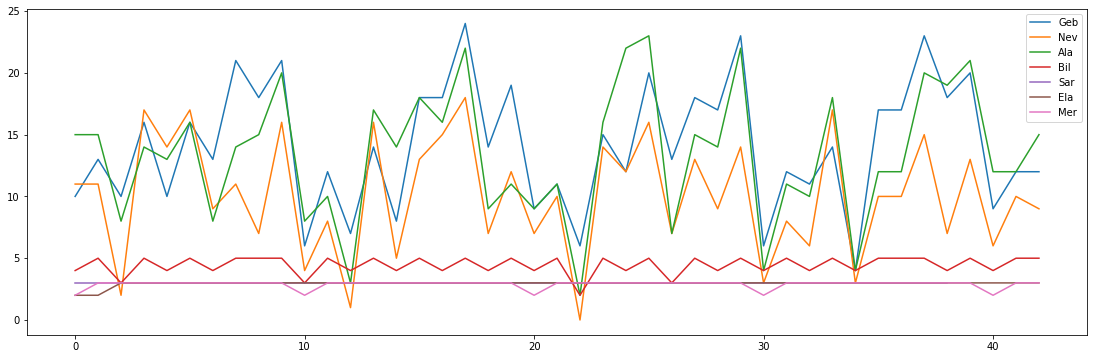

In [ ]:
fig, ax = plt.subplots(figsize=(19,6))
for i in range(exit_points):
    plt.plot(vehicle_avail[i])
    if plan_for == "ded_only":
        plt.legend(["Geb", "Nev", "Ala"], loc='upper right')
    else:
        plt.legend(["Geb", "Nev", "Ala","Bil", "Sar", "Ela", "Mer"] , loc='upper right')
plt.show

****
GARBAGE BELOW
*****

In [ ]:
ch=15;
locs=[];
for locat in customers:
  locs.append(locat)

locs[ch].tr_o

0

In [ ]:
ll=[0,1,0,1,0,0,0,0,0,0,1]
if not sum(ll):
  print('a')
else:
  print('b')

b


In [ ]:
k=[1,1,1,1,1,2,2,2,2,3,3,4,5,6,7,9,10,5,8,9,7,4,6,5]
m=unique(k)
for i in range(len(m)):
  c=k.count(m[i])
  print("eleman: {0} - count: {1}".format(m[i],c))

eleman: 1 - count: 5
eleman: 2 - count: 4
eleman: 3 - count: 2
eleman: 4 - count: 2
eleman: 5 - count: 3
eleman: 6 - count: 2
eleman: 7 - count: 2
eleman: 9 - count: 2
eleman: 10 - count: 1
eleman: 8 - count: 1


In [ ]:
            for v in spot_fleets[i].v:                                                  #similarly
                if not v.returned and (v.return_time < time or plan_for =="spot_only"): 
                    v.returned = True; spot_fleets[i].v_return(v); v.rem_cap = v.cap   
                    if plan_for != "spot_only":
                        print("#RETURN: ",v.plate, " returned to ", v.base.name)        #print the return

In [ ]:
for k in [168]:    
    print(customers[k].serviceLevel)

[0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1]


In [ ]:
services=[]
for cust in customers:
    if not cust.passive:
        services.append(np.max(cust.days_since_ship))

print(plan_for, "%.3f" %np.mean(services))

spot_only 0.311


In [ ]:
for time in np.linspace(0,maxdays,int(1 + maxdays / time_increment)):
    if time%1 < .5:
        if (int(time)+1)%7 != 0 and int(time)%7 !=0:
            print(time)


In [ ]:
target = [23,8,19,98,20,89,64]

means= [50 for q in range(len(target))]
stds= [10 for q in range(len(target))]



In [ ]:
np.random.normal(means,stds,len(target))

array([42.63407262, 56.88029673, 58.86586004, 66.46793068, 39.39630678,
       44.72604203, 64.82454269])

In [ ]:
sisters = []
sisters = [np.random.normal(means,stds,len(target)) for q in range(len(target))]
sisters


[array([56.21072716, 67.41666964, 57.27099298, 45.27384631, 73.98224914,
        58.4477492 , 58.53885792]),
 array([41.03036857, 51.48559647, 46.95885983, 65.30011672, 52.13476206,
        39.8964511 , 34.40274848]),
 array([47.23956196, 26.25946995, 61.09108315, 42.13975766, 55.59460507,
        35.45750433, 54.79075753]),
 array([45.73069683, 51.08218952, 40.84075809, 46.49756044, 46.49869159,
        64.22020367, 50.37624611]),
 array([53.25495028, 41.07165882, 44.20119964, 66.31691892, 48.62049828,
        54.41274047, 37.93336007]),
 array([25.47288534, 54.34424116, 34.73235165, 38.46046263, 46.0254074 ,
        36.18074816, 42.92310605]),
 array([45.60598948, 64.95623911, 60.345225  , 43.13731795, 54.18831111,
        36.92326978, 45.61463848])]

In [ ]:
target = [23,8,19,98,20,89,64]

means= [50 for q in range(len(target))]
stds= [1 for q in range(len(target))]
progress=[]
gen_size=14
best_fitness=999
while best_fitness > 5:
    sisters = []
    sisters = [np.random.normal(means,stds,len(target)) for q in range(gen_size)]
    fitness = [np.linalg.norm(np.array(sister)- np.array(target)) for sister in sisters]
    champion = sisters[np.argmin(fitness)]
    best_fitness = np.min(fitness)
    progress.append(best_fitness)
    means = champion
progress[-1]

4.438360197981411

In [ ]:
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(progress)

In [ ]:
q=np.array((1,2))
w=np.array((4,6))
np.linalg.norm(q-w)

5.0

In [ ]:
val_names[0][0]

'0'

In [ ]:
target = [30,40,50,50,60,70]
val_names=[]
for i in range(len(target)):
    val_names.append([str(i)])

def objective(trial):
    sister=[]
    for i in range(len(target)):
        sister.append(trial.suggest_int(val_names[i][0], 0, 100))
    return np.linalg.norm(np.array(sister)- np.array(target))

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=60)


[I 2021-03-12 22:34:16,047] A new study created in memory with name: no-name-601664af-3ebc-44fa-a660-ebc049dd2b12
[I 2021-03-12 22:34:16,052] Trial 0 finished with value: 77.22693830523129 and parameters: {'0': 1, '1': 88, '2': 66, '3': 99, '4': 69, '5': 79}. Best is trial 0 with value: 77.22693830523129.
[I 2021-03-12 22:34:16,057] Trial 1 finished with value: 55.758407437802596 and parameters: {'0': 58, '1': 40, '2': 12, '3': 34, '4': 67, '5': 46}. Best is trial 1 with value: 55.758407437802596.
[I 2021-03-12 22:34:16,063] Trial 2 finished with value: 52.01922721455981 and parameters: {'0': 68, '1': 63, '2': 54, '3': 60, '4': 41, '5': 54}. Best is trial 2 with value: 52.01922721455981.
[I 2021-03-12 22:34:16,067] Trial 3 finished with value: 46.67976006793523 and parameters: {'0': 62, '1': 59, '2': 59, '3': 30, '4': 73, '5': 58}. Best is trial 3 with value: 46.67976006793523.
[I 2021-03-12 22:34:16,074] Trial 4 finished with value: 44.01136216933077 and parameters: {'0': 42, '1': 35,

In [ ]:
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    y = trial.suggest_int("y", -10, 10)
    return x ** 2 - y


sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=80)